In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
from scipy import stats
import warnings
import os
import folium
import json
import seaborn as sns
warnings.filterwarnings('ignore')

In [2]:
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.utils import resample

We load the data into a Pandas dataframe. A row of our dataframe will look as follows:

| CountryName| Country |  IndicatorName | Indicator  | Units | Scale | Frequency | Date | Value
| :----:|:-------------:| :-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|
| Tunisia | TUN | Inflation, consumer prices (annual %) | FP.CPI.TOTL.ZG | 	annual % | 1 | A | 1980-01-01 | 6.1

Our data contains thus several socio-economic indicators for the african countries 

Loading the data and doing some basic preprocessing

In [3]:
DATA_PATH = "data/"
AFDB_2019 = "Data.csv"
initial_data = pd.read_csv(DATA_PATH + AFDB_2019, sep=',')

#the drop didn't change the shape of our dataset
initial_data.dropna(subset=['Date', 'Value','Country','Indicator'],inplace = True) 

#retrieving only the year from the date column
initial_data.Date = initial_data.Date.apply(lambda x : x.split("-")[0]).astype(int)
initial_data.rename(columns = {'Date':'Year'}, inplace = True)
initial_data.Scale = initial_data.Scale.astype(int)
#initial_data.Value = initial_data.Value.astype(float)
initial_data.head()

,CountryName,Country,IndicatorName,Indicator,Units,Scale,Frequency,Year,Value
0,AFRICA,AFR,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,annual %,1,A,2000,9.133374
1,AFRICA,AFR,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,annual %,1,A,2001,8.535367
2,AFRICA,AFR,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,annual %,1,A,2002,7.238168
3,AFRICA,AFR,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,annual %,1,A,2003,7.217622
4,AFRICA,AFR,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,annual %,1,A,2004,7.373657


Loading the indicators data that contains the name and the code for all the indicators present in our initial dataset 

In [4]:
INDICATORS = "Indicator.csv"
indicators_data = pd.read_csv(DATA_PATH + INDICATORS, sep=',')
indicators_data = indicators_data[['Order','Name','Code']]
indicators_data.head()

,Order,Name,Code
0,1,Prices,KN.B1
1,2,"Inflation, consumer prices index (2000 = 100)",FP.CPI.TOTL
2,3,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG
3,4,"Consumer Price Index, in Clothing and Footwear...",CTRY.FP.CPI.CLF
4,5,"Consumer Price Index, in Communication (% change)",CTRY.FP.CPI.COM


In [5]:
all_years = np.sort(initial_data.Year.unique())
all_years

array([1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025,
       2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036,
       2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047,
       2048, 2049, 2050])

We can see that we have data from 1960 till 2050 in our initial dataset we will just pick up the data from 1960 to 2019

In [6]:
initial_data = initial_data[initial_data.Year < 2020]

In [7]:
indicators_by_year = pd.pivot_table(initial_data, values='Value', index=['Country','Year'], columns=['Indicator'])
indicators_by_year

Indicator     AFDB_CPIA_EM_DB_S  AFDB_CPIA_EM_FP_S  AFDB_CPIA_EM_MM_S  \
Country Year                                                            
ADB     1960                NaN                NaN                NaN   
        1961                NaN                NaN                NaN   
        1962                NaN                NaN                NaN   
        1963                NaN                NaN                NaN   
        1964                NaN                NaN                NaN   
...                         ...                ...                ...   
ZZM     2015                NaN                NaN                NaN   
        2016                NaN                NaN                NaN   
        2017                NaN                NaN                NaN   
        2018                NaN                NaN                NaN   
        2019                NaN                NaN                NaN   

Indicator     AFDB_CPIA_EM_S  AFDB_CPIA_IRI_ID_S  AFDB_CPIA_IRI_RI_S  \
Country Year                                                           
ADB     1960             NaN                 NaN                 NaN   
        1961             NaN                 NaN                 NaN   
        1962             NaN                 NaN                 NaN   
        1963             NaN                 NaN                 NaN   
        1964             NaN                 NaN                 NaN   
...                      ...                 ...                 ...   
ZZM     2015             NaN                 NaN                 NaN   
        2016             NaN                 NaN                 NaN   
        2017             NaN                 NaN                 NaN   
        2018             NaN                 NaN                 NaN   
        2019             NaN                 NaN                 NaN   

Indicator     AFDB_CPIA_N  AFDB_CPIA_PSIE_BHR_S  AFDB_CPIA_PSIE_EPRU_S  \
Country Year                                                             
ADB     1960          NaN                   NaN                    NaN   
        1961          NaN                   NaN                    NaN   
        1962          NaN                   NaN                    NaN   
        1963          NaN                   NaN                    NaN   
        1964          NaN                   NaN                    NaN   
...                   ...                   ...                    ...   
ZZM     2015          NaN                   NaN                    NaN   
        2016          NaN                   NaN                    NaN   
        2017          NaN                   NaN                    NaN   
        2018          NaN                   NaN                    NaN   
        2019          NaN                   NaN                    NaN   

Indicator     AFDB_CPIA_PSIE_EPR_S  ...  TG.WEO.TXGXO_R.KD  TG.WEO.TXG_D.WD  \
Country Year                        ...                                       
ADB     1960                   NaN  ...                NaN              NaN   
        1961                   NaN  ...                NaN              NaN   
        1962                   NaN  ...                NaN              NaN   
        1963                   NaN  ...                NaN              NaN   
        1964                   NaN  ...                NaN              NaN   
...                            ...  ...                ...              ...   
ZZM     2015                   NaN  ...                NaN              NaN   
        2016                   NaN  ...                NaN              NaN   
        2017                   NaN  ...                NaN              NaN   
        2018                   NaN  ...                NaN              NaN   
        2019                   NaN  ...                NaN              NaN   

Indicator     TG.WEO.TXG_R.KD  TG.WEO.TXG_R.ZG  TG.WEO.TXS.CD  TG.WEO.TX_D.WD  \
Country Year                             

We see that in our initial dataframe we don't have only countries but also some data for regions(regrouped countries), and also for the entire continent we suppose that it is an estimation for the average values of all the countries indicators. We also observe that we have in `indicators_by_year` many missing values essentially in the first years when looking deeper into the dataset so we will retrieve only the countries plus the african data for further alysis and analyse the occurence of this missing values to know how to deal with them 

In [8]:
# array of the African countries name plus the African continent 
Countries_Only = ['AFRICA','Cameroon', 'Central African Republic','Chad', 'Congo, Dem. Rep.', 'Congo, Rep.', 'Equatorial Guinea',
                 'Gabon', 'Sao Tome and Principe', 'Burundi', 'Comoros', 'Djibouti', 'Eritrea', 'Ethiopia','Kenya',
                 'Rwanda', 'Seychelles', 'Somalia', 'South Sudan', 'Sudan', 'Tanzania', 'Uganda', 'Algeria', 'Egypt',
                 'Libya', 'Mauritania', 'Morocco', 'Tunisia', 'Angola', 'Botswana', 'Lesotho', 'Madagascar', 'Malawi',
                 'Mauritius', 'Mozambique', 'Namibia', 'South Africa', 'Swaziland', 'Zambia', 'Zimbabwe', 'Benin',
                 'Burkina Faso', 'Cape Verde', "Cote d'Ivoire", 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Liberia',
                 'Mali', 'Niger', 'Nigeria', 'Senegal', 'Sierra Leone','Togo']

In [9]:
missing_dates = initial_data[['CountryName','Country','Year','Indicator','Value']]
missing_dates = missing_dates[missing_dates.CountryName.isin(Countries_Only)]
missing_dates['Value'].replace(0, np.nan, inplace=True)
missing_dates['MissingValues'] = missing_dates.isnull().sum(axis = 1)
missing_dates = missing_dates[['Year','MissingValues']].groupby(['Year']).sum()
missing_dates = missing_dates.reset_index() 

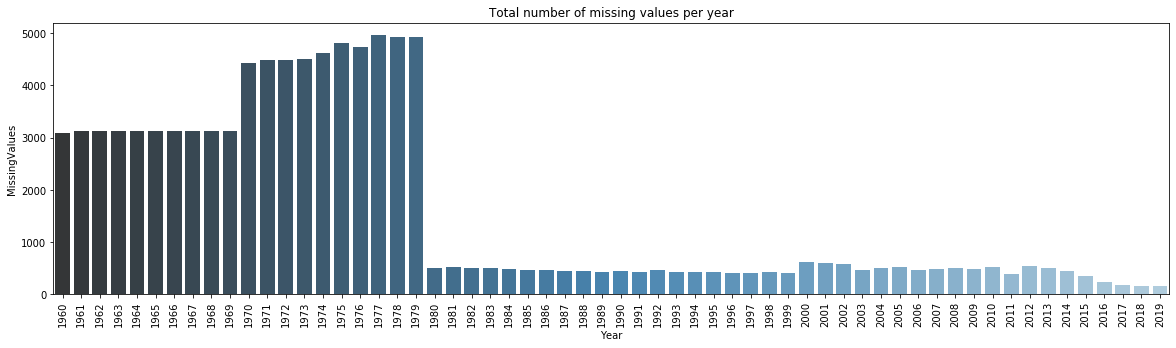

In [10]:
plt.figure(figsize=(20,5))
pl = sns.barplot(missing_dates.Year, y=missing_dates.MissingValues, palette="Blues_d")
pl.set_xticklabels(missing_dates.Year,rotation=90)
pl.set_title('Total number of missing values per year')
plt.show()

In [11]:
ind_by_year = initial_data[['CountryName','Country','Year','Indicator','Value']]
ind_by_year = ind_by_year[ind_by_year.CountryName.isin(Countries_Only)]

ind_by_year = ind_by_year[['Year','Indicator']].groupby(['Year']).count()
ind_by_year = ind_by_year.reset_index() 

In [12]:
len(Countries_Only)

55

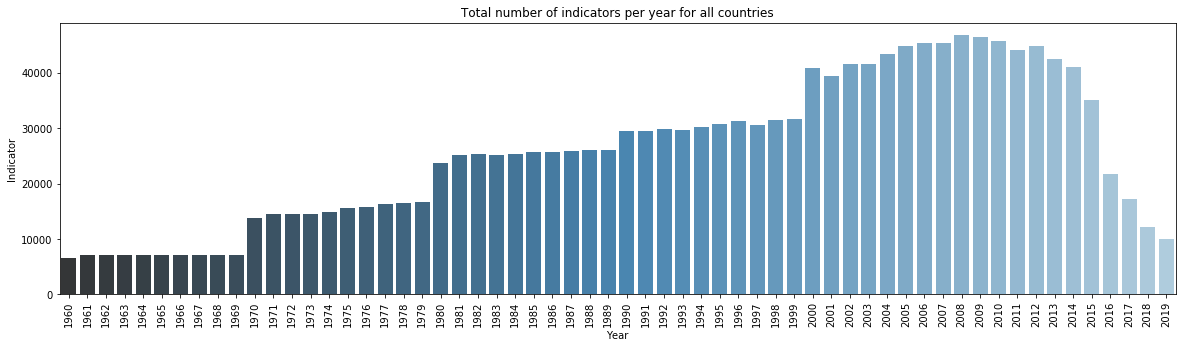

In [13]:
plt.figure(figsize=(20,5))
pl = sns.barplot(ind_by_year.Year, y=ind_by_year.Indicator, palette="Blues_d")
pl.set_xticklabels(ind_by_year.Year,rotation=90)
pl.set_title('Total number of indicators per year for all countries')
plt.show()

In [14]:
percentage_missing = missing_dates.set_index('Year').join(ind_by_year.set_index('Year'))
percentage_missing['Percentage'] = round(percentage_missing['MissingValues'] / percentage_missing['Indicator'] * 100,2)

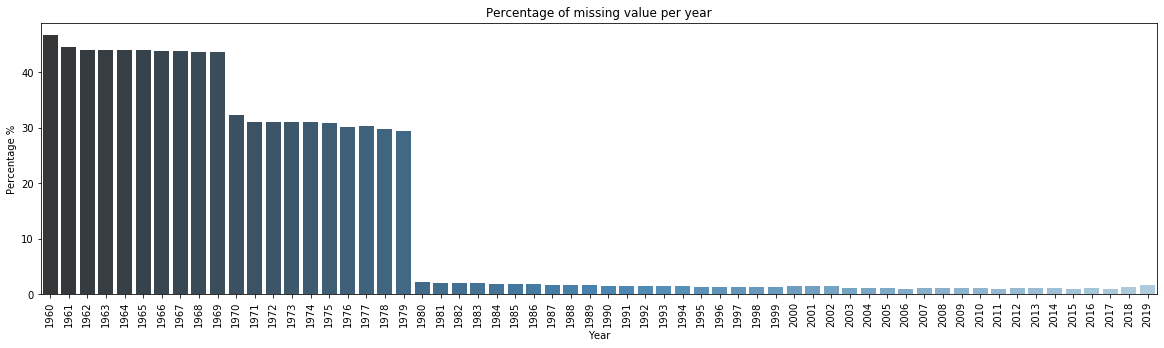

In [15]:
plt.figure(figsize=(20,5))
pl = sns.barplot(percentage_missing.index, y=percentage_missing.Percentage, palette="Blues_d")
pl.set_xticklabels(percentage_missing.index,rotation=90)
pl.set_title('Percentage of missing value per year')
pl.set_ylabel('Percentage %')
plt.show()

In [16]:
countries_data = initial_data[initial_data.CountryName.isin(Countries_Only)]
indicators_country_year = pd.pivot_table(countries_data, values='Value', index=['Country','Year'], columns=['Indicator'])
indicators_country_year

Indicator     AFDB_CPIA_EM_DB_S  AFDB_CPIA_EM_FP_S  AFDB_CPIA_EM_MM_S  \
Country Year                                                            
AFR     1960                NaN                NaN                NaN   
        1961                NaN                NaN                NaN   
        1962                NaN                NaN                NaN   
        1963                NaN                NaN                NaN   
        1964                NaN                NaN                NaN   
...                         ...                ...                ...   
ZWE     2015                2.5                2.5                3.0   
        2016                2.5                2.0                3.0   
        2017                NaN                NaN                NaN   
        2018                NaN                NaN                NaN   
        2019                NaN                NaN                NaN   

Indicator     AFDB_CPIA_EM_S  AFDB_CPIA_IRI_ID_S  AFDB_CPIA_IRI_RI_S  \
Country Year                                                           
AFR     1960             NaN                 NaN                 NaN   
        1961             NaN                 NaN                 NaN   
        1962             NaN                 NaN                 NaN   
        1963             NaN                 NaN                 NaN   
        1964             NaN                 NaN                 NaN   
...                      ...                 ...                 ...   
ZWE     2015             NaN                 2.7                2.50   
        2016             NaN                 2.7                2.75   
        2017             NaN                 NaN                 NaN   
        2018             NaN                 NaN                 NaN   
        2019             NaN                 NaN                 NaN   

Indicator     AFDB_CPIA_N  AFDB_CPIA_PSIE_BHR_S  AFDB_CPIA_PSIE_EPRU_S  \
Country Year                                                             
AFR     1960          NaN                   NaN                    NaN   
        1961          NaN                   NaN                    NaN   
        1962          NaN                   NaN                    NaN   
        1963          NaN                   NaN                    NaN   
        1964          NaN                   NaN                    NaN   
...                   ...                   ...                    ...   
ZWE     2015          NaN               3.33333                2.16667   
        2016          NaN               3.66667                2.16667   
        2017          NaN                   NaN                    NaN   
        2018          NaN                   NaN                    NaN   
        2019          NaN                   NaN                    NaN   

Indicator     AFDB_CPIA_PSIE_EPR_S  ...  TG.WEO.TXGXO_R.KD  TG.WEO.TXG_D.WD  \
Country Year                        ...                                       
AFR     1960                   NaN  ...                NaN              NaN   
        1961                   NaN  ...                NaN              NaN   
        1962                   NaN  ...                NaN              NaN   
        1963                   NaN  ...                NaN              NaN   
        1964                   NaN  ...                NaN              NaN   
...                            ...  ...                ...              ...   
ZWE     2015                   2.5  ...       1.260197e+09       286.796901   
        2016                   2.5  ...       1.319484e+09       280.518802   
        2017                   NaN  ...       1.263811e+09       302.366614   
        2018                   NaN  ...       1.331340e+09       299.264516   
        2019                   NaN  ...       1.410437e+09       296.748918   

Indicator     TG.WEO.TXG_R.KD  TG.WEO.TXG_R.ZG  TG.WEO.TXS.CD  TG.WEO.TX_D.WD  \
Country Year                             

In [17]:
indicators_country_year['Count'] = indicators_country_year.apply(lambda x: x.count(), axis=1)
indicators_country_year['Count']
indicators_by_country = indicators_country_year['Count']

In [18]:
indicators_by_country_np = indicators_by_country.to_numpy()
indicators_by_country_np = indicators_by_country_np.reshape((55,60))

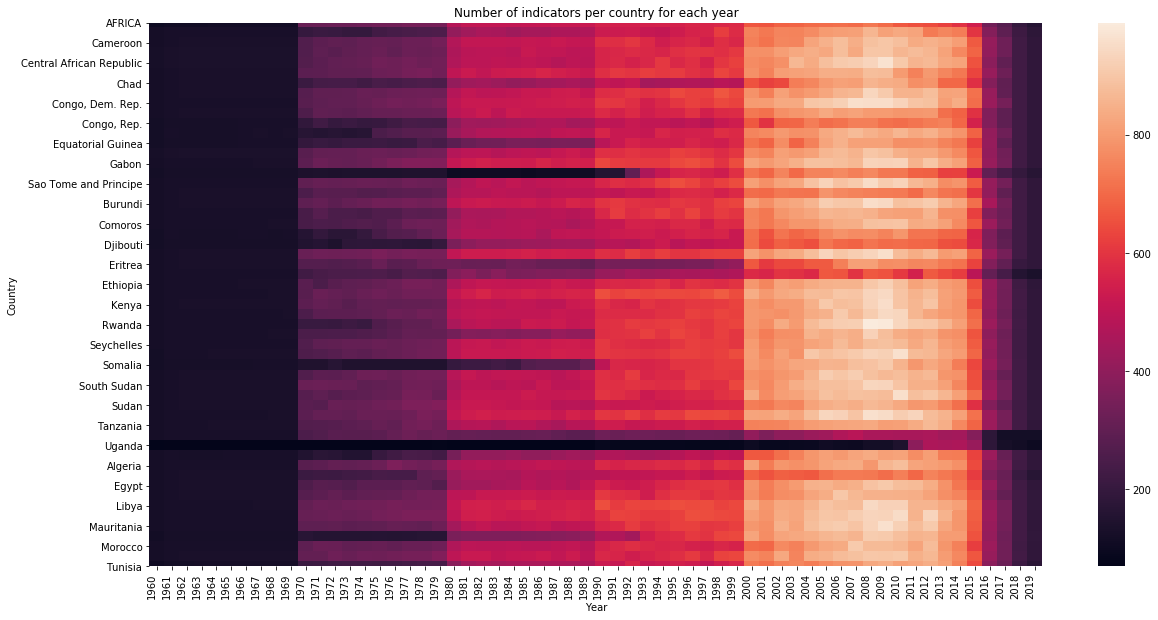

In [19]:
plt.subplots(figsize=(20,10))
x_ticks = np.arange(1960,2020)
y_ticks = Countries_Only
heatmap = sns.heatmap(indicators_by_country_np)
heatmap.set_xticklabels(x_ticks, rotation=90, horizontalalignment='right')
heatmap.set_yticklabels(y_ticks, rotation=0, horizontalalignment='right')
heatmap.set_xlabel('Year')
heatmap.set_ylabel('Country')
heatmap.set_title('Number of indicators per country for each year')
plt.show()

In [20]:
def lowercase_all(text):
    return text.lower()

In [21]:
education_keywords = ['education','literacy','enrol','school','teach','pupil','stud','repeat',
                      'test','search','grade','intern','knowledge','lab','read','prof','write','report','skill']

'''
['university','department','degree','learn','college','academic','assessment','class','course','curriculum','exam',
'faculty','instruct','intellect','language','quizz', ..etc] 
These keywords and many others didn't add a single row to the result, Hence we discarded them.
We have chosen these keywords based on the data examined manually to look a bit what we are dealing with, and from well known
education related dictionaries.
'''

inds_education = indicators_data[indicators_data.Name.apply(lowercase_all).str.contains('|'.join(education_keywords))]
inds_education

,Order,Name,Code
31,32,Internet users per 100 inhabitants,IT.NET.USER.P3
32,33,Proportion of individuals using the Internet,IT.USE.ii99
42,43,Internet users,IT.NET.USER
43,44,Internet Subscribers,IT.NET.SCRB
46,47,Fixed Internet broadband Subscriptions per 100...,IT.NET.BBND
...,...,...,...
1637,1638,Teaching staff at third level - Total (number),CTRY.SE.TCHR.THIRD
1638,1639,Third level student enrollment - Female (number),CTRY.SE.TER.ENRR.FE.TOT
1639,1640,Third level student enrollment - Total (number),CTRY.SE.TER.ENRR.TOT
1640,1641,Public expenditure on education (% of budget),CTRY.SE.XPD.BUDG.ZS


In [25]:
education_codes = inds_education.Code.unique().tolist()
db_education = countries_data[countries_data.Indicator.str.match('|'.join(education_codes))]
db_education

,CountryName,Country,IndicatorName,Indicator,Units,Scale,Frequency,Year,Value
399,AFRICA,AFR,Internet users per 100 inhabitants,IT.NET.USER.P3,per 100 inhabitants,1,A,1991,0.000737
400,AFRICA,AFR,Internet users per 100 inhabitants,IT.NET.USER.P3,per 100 inhabitants,1,A,1992,0.002143
401,AFRICA,AFR,Internet users per 100 inhabitants,IT.NET.USER.P3,per 100 inhabitants,1,A,1993,0.006324
402,AFRICA,AFR,Internet users per 100 inhabitants,IT.NET.USER.P3,per 100 inhabitants,1,A,1994,0.014261
403,AFRICA,AFR,Internet users per 100 inhabitants,IT.NET.USER.P3,per 100 inhabitants,1,A,1995,0.040432
...,...,...,...,...,...,...,...,...,...
2790080,Sierra Leone,SLE,Employing Workers - Nonwage labor cost (% of s...,PS.DB.EW.NW.LC.IN,% of salary,1,A,2006,10.000000
2790081,Sierra Leone,SLE,Employing Workers - Nonwage labor cost (% of s...,PS.DB.EW.NW.LC.IN,% of salary,1,A,2007,10.000000
2790089,Togo,TGO,Employing Workers - Nonwage labor cost (% of s...,PS.DB.EW.NW.LC.IN,% of salary,1,A,2005,25.000000
2790090,Togo,TGO,Employing Workers - Nonwage labor cost (% of s...,PS.DB.EW.NW.LC.IN,% of salary,1,A,2006,25.000000


In [26]:
db_ed = pd.pivot_table(db_education, values='Value', index=['Country', 'Year'], columns=['Indicator'])

#thresh=N requires that a column has at least N non-NaNs to survive
#We chose to work with an indicator if at least half of its values are not missing.

th = 0.5
print(db_ed.shape)
db_ed.dropna(axis=1,thresh=int(th*db_ed.shape[0]),inplace=True)
print(db_ed.shape)

(3281, 161)
(3281, 27)


Now it's time to check manually the description of the 28 selected attributes (indicators) to see if they are really
education-related, hence relevant for our study, or not.
Because until now the only filter we have done is selecting indicators with description containing one of those 
education-related keywords from above.

In [27]:
inds_educ_after_nan_codes = indicators_data[indicators_data.Code.str.match('|'.join(db_ed.columns))]
#inds_educ_after_nan_codes = inds_educ_after_nan_codes[['Code','Name','Source_Note']]
inds_educ_after_nan_codes = inds_educ_after_nan_codes[['Code','Name']]
inds_educ_after_nan_codes

,Code,Name
236,AG.POP.EAC.TOT.ZS,Labour force participation (as % of total)
383,PA.NUS.PPP,Purchasing power parity conversion factor (LCU...
418,NY.GDP.PCAP.PP.CD,"GDP Per capita, PPP (current international $)"
1242,FI.RES.TOTL.MO,Gross international reserves in months of imports
1243,FI.RES.TOTL.CD,Gross international reserves (current US$)
1287,SE.ENR.PRIM.FM.ZS,Ratio of female to male primary enrollment
1289,SE.PRM.ENRL.TC.ZS,"Pupil-teacher ratio, primary"
1290,SE.PRM.ENRR,"School enrollment, primary (% gross)"
1291,SE.PRM.ENRR.FE,"School enrollment, primary, female (% gross)"
1292,SE.PRM.ENRR.MA,"School enrollment, primary, male (% gross)"


We see that the first 4 shown indicators, which are:

AG.POP.EAC.TOT.ZS   -    Labour force participation (as % of total)

NY.GDP.PCAP.PP.CD   -    GDP Per capita, PPP (current international D)

FI.RES.TOTL.MO      -    Gross international reserves in months of imports

FI.RES.TOTL.CD      -    Gross international reserves (current USD)

These have nothing to do with what we are looking for, they were only present because of the keywords : "lab" for the first
indicator when looking for potential description including a laboratory, and "intern" for the 3 others when looking 
for potential description including an intern student or an internship ..

Hence we can exclude these 4 indicators.

In [28]:
print(db_ed.shape)
db_ed = db_ed.drop(columns=['AG.POP.EAC.TOT.ZS','NY.GDP.PCAP.PP.CD','FI.RES.TOTL.MO','FI.RES.TOTL.CD'])
db_ed.shape

(3281, 27)


(3281, 23)

### Correlation plots between the education attributes

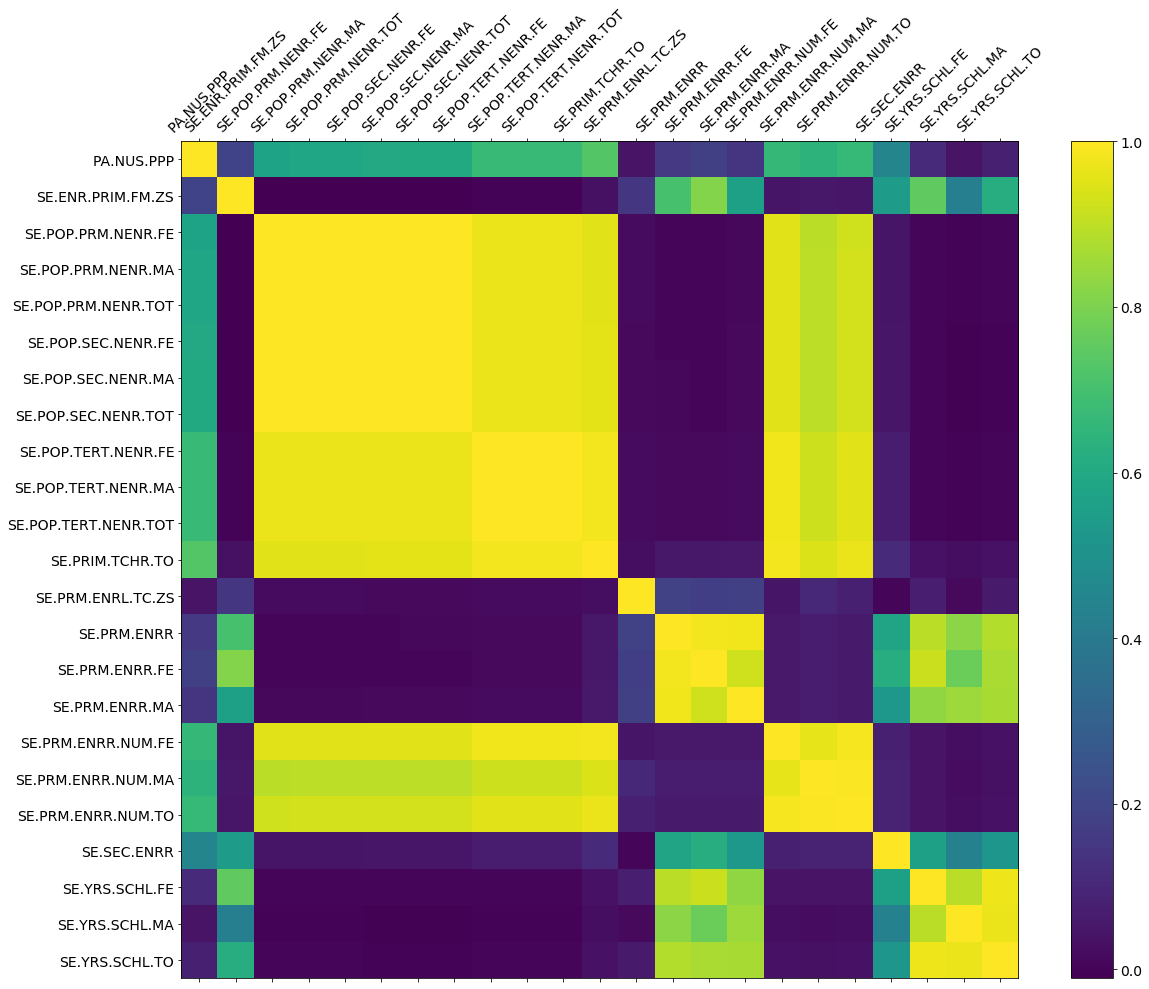

In [29]:
f = plt.figure(figsize=(19, 15))
plt.matshow(db_ed.corr(), fignum=f.number)
plt.xticks(range(db_ed.shape[1]), db_ed.columns, fontsize=14, rotation=45)
plt.yticks(range(db_ed.shape[1]), db_ed.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

In [30]:
corr = db_ed.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

Indicator,PA.NUS.PPP,SE.ENR.PRIM.FM.ZS,SE.POP.PRM.NENR.FE,SE.POP.PRM.NENR.MA,SE.POP.PRM.NENR.TOT,SE.POP.SEC.NENR.FE,SE.POP.SEC.NENR.MA,SE.POP.SEC.NENR.TOT,SE.POP.TERT.NENR.FE,SE.POP.TERT.NENR.MA,SE.POP.TERT.NENR.TOT,SE.PRIM.TCHR.TO,SE.PRM.ENRL.TC.ZS,SE.PRM.ENRR,SE.PRM.ENRR.FE,SE.PRM.ENRR.MA,SE.PRM.ENRR.NUM.FE,SE.PRM.ENRR.NUM.MA,SE.PRM.ENRR.NUM.TO,SE.SEC.ENRR,SE.YRS.SCHL.FE,SE.YRS.SCHL.MA,SE.YRS.SCHL.TO
Indicator,,,,,,,,,,,,,,,,,,,,,,,
PA.NUS.PPP,1,0.192,0.575,0.588,0.582,0.598,0.605,0.601,0.673,0.675,0.674,0.73,0.0432,0.157,0.179,0.143,0.661,0.644,0.665,0.449,0.109,0.0442,0.0798
SE.ENR.PRIM.FM.ZS,0.192,1,-0.0086,-0.00776,-0.00817,-0.0108,-0.01,-0.0104,-0.000182,0.00065,0.000235,0.0328,0.149,0.708,0.811,0.562,0.0445,0.0551,0.0507,0.549,0.755,0.426,0.62
SE.POP.PRM.NENR.FE,0.575,-0.0086,1,1,1,0.999,0.999,0.999,0.969,0.969,0.969,0.955,0.0179,0.0072,0.00666,0.0105,0.954,0.897,0.929,0.0454,0.00753,-0.00111,0.0032
SE.POP.PRM.NENR.MA,0.588,-0.00776,1,1,1,0.999,0.999,0.999,0.969,0.969,0.969,0.956,0.0179,0.00769,0.00727,0.0109,0.955,0.898,0.93,0.0476,0.00772,-0.00119,0.0033
SE.POP.PRM.NENR.TOT,0.582,-0.00817,1,1,1,0.999,0.999,0.999,0.969,0.969,0.969,0.956,0.0179,0.00745,0.00697,0.0107,0.955,0.898,0.929,0.0465,0.00763,-0.00115,0.00325
SE.POP.SEC.NENR.FE,0.598,-0.0108,0.999,0.999,0.999,1,1,1,0.972,0.971,0.972,0.958,0.0157,0.00887,0.00765,0.0131,0.955,0.898,0.93,0.0502,0.00459,-0.00333,0.000608
SE.POP.SEC.NENR.MA,0.605,-0.01,0.999,0.999,0.999,1,1,1,0.971,0.971,0.971,0.958,0.0154,0.00948,0.00833,0.0137,0.956,0.899,0.93,0.0523,0.00487,-0.00326,0.000824
SE.POP.SEC.NENR.TOT,0.601,-0.0104,0.999,0.999,0.999,1,1,1,0.972,0.971,0.971,0.958,0.0155,0.00918,0.00799,0.0134,0.955,0.898,0.93,0.0512,0.00473,-0.0033,0.000717
SE.POP.TERT.NENR.FE,0.673,-0.000182,0.969,0.969,0.969,0.972,0.971,0.972,1,1,1,0.981,0.0183,0.0146,0.015,0.0173,0.978,0.923,0.954,0.0652,0.00772,-0.0021,0.00277


In [31]:
# Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
to_drop

['SE.POP.PRM.NENR.MA',
 'SE.POP.PRM.NENR.TOT',
 'SE.POP.SEC.NENR.FE',
 'SE.POP.SEC.NENR.MA',
 'SE.POP.SEC.NENR.TOT',
 'SE.POP.TERT.NENR.FE',
 'SE.POP.TERT.NENR.MA',
 'SE.POP.TERT.NENR.TOT',
 'SE.PRIM.TCHR.TO',
 'SE.PRM.ENRR.FE',
 'SE.PRM.ENRR.MA',
 'SE.PRM.ENRR.NUM.FE',
 'SE.PRM.ENRR.NUM.MA',
 'SE.PRM.ENRR.NUM.TO',
 'SE.YRS.SCHL.TO']

In [32]:
to_keep = [element for element in upper.columns if element not in to_drop]
db_keep = db_ed[to_keep]
print(db_keep.shape)
to_keep

(3281, 8)


['PA.NUS.PPP',
 'SE.ENR.PRIM.FM.ZS',
 'SE.POP.PRM.NENR.FE',
 'SE.PRM.ENRL.TC.ZS',
 'SE.PRM.ENRR',
 'SE.SEC.ENRR',
 'SE.YRS.SCHL.FE',
 'SE.YRS.SCHL.MA']

What we're doing here is just replacing the School age population Primary-Female (SE.POP.PRM.NENR.FE) with the School 
age population Primary-Total and The Primary school teachers-Female (SE.PRIM.TCHR.FE) with the Enrolment in total 
primary-Total. (These are very correlated, we just did the replacement for name convenience, won't affect our findings)

In [33]:
to_keep = pd.Series(to_keep).replace(['SE.POP.PRM.NENR.FE', 'SE.PRIM.TCHR.FE'],
                                     ['SE.POP.PRM.NENR.TOT', 'SE.PRM.ENRR.NUM.TO']).tolist()
to_keep

['PA.NUS.PPP',
 'SE.ENR.PRIM.FM.ZS',
 'SE.POP.PRM.NENR.TOT',
 'SE.PRM.ENRL.TC.ZS',
 'SE.PRM.ENRR',
 'SE.SEC.ENRR',
 'SE.YRS.SCHL.FE',
 'SE.YRS.SCHL.MA']

### Final correlation Matrix

In [34]:
db_final_ed = db_ed[to_keep]
corr_keep = db_final_ed.corr()
corr_keep.style.background_gradient(cmap='coolwarm').set_precision(3)

Indicator,PA.NUS.PPP,SE.ENR.PRIM.FM.ZS,SE.POP.PRM.NENR.TOT,SE.PRM.ENRL.TC.ZS,SE.PRM.ENRR,SE.SEC.ENRR,SE.YRS.SCHL.FE,SE.YRS.SCHL.MA
Indicator,,,,,,,,
PA.NUS.PPP,1,0.192,0.582,0.0432,0.157,0.449,0.109,0.0442
SE.ENR.PRIM.FM.ZS,0.192,1,-0.00817,0.149,0.708,0.549,0.755,0.426
SE.POP.PRM.NENR.TOT,0.582,-0.00817,1,0.0179,0.00745,0.0465,0.00763,-0.00115
SE.PRM.ENRL.TC.ZS,0.0432,0.149,0.0179,1,0.186,0.00272,0.0726,0.0139
SE.PRM.ENRR,0.157,0.708,0.00745,0.186,1,0.578,0.896,0.825
SE.SEC.ENRR,0.449,0.549,0.0465,0.00272,0.578,1,0.562,0.433
SE.YRS.SCHL.FE,0.109,0.755,0.00763,0.0726,0.896,0.562,1,0.895
SE.YRS.SCHL.MA,0.0442,0.426,-0.00115,0.0139,0.825,0.433,0.895,1


We conclude our final Education related attributes that we're gonna work with:


1. SE.POP.PRM.NENR.TOT - School age population Primary Total 

From correlation observations, this also represents the School age population for Secondary and Tertiaty.


2. SE.PRM.ENRR.NUM.TO  - Enrollment in total primary, Total

From correlation observations, this also represents the Enrollment in total for Secondary School as well as the number
of (primary) school teachers.


3. SE.PRM.ENRL.TC.ZS   - Pupil-teacher ratio, primary

4. SE.PRM.ENRR         - School enrollment, primary (% gross)

5. SE.YRS.SCHL.FE      - School Life Expectancy - Female (years)

6. SE.YRS.SCHL.MA      - School Life Expectancy - Male (years)


We let the School life expectancy for Females and Males separated because we found out they are not very correlated
and hence can lead us to good/unexpected results.

Text(0.5,1,'School Life Expectancy (Male)')

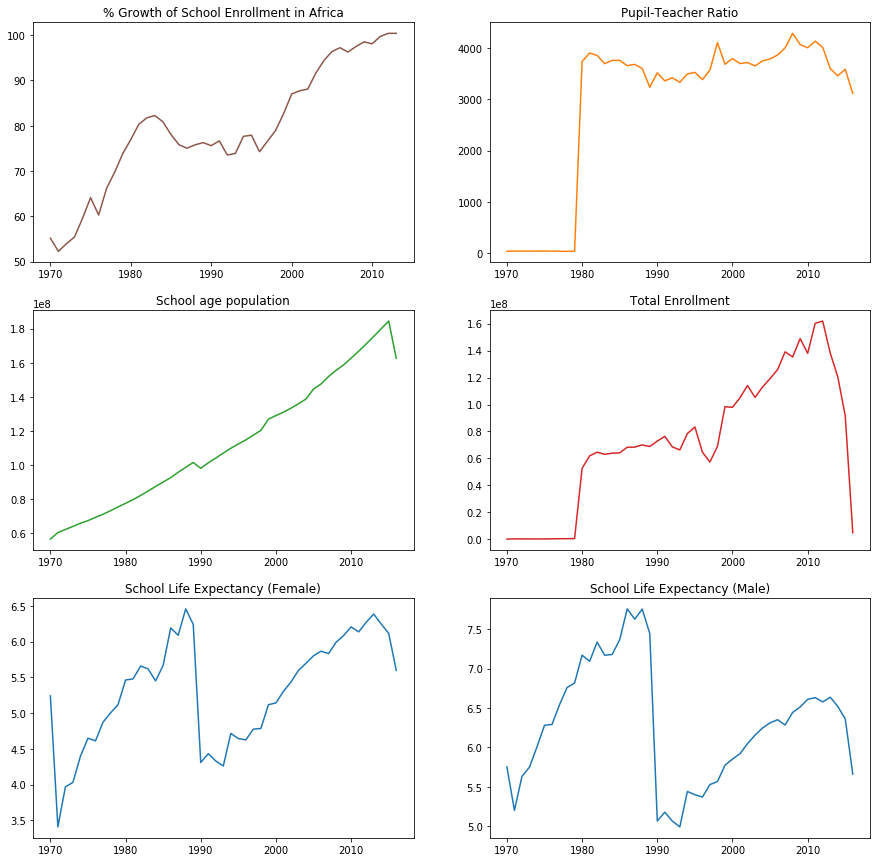

In [35]:
#Plots of chosen variables:

db_afr_indexes = countries_data[['Country','Year','Indicator','Value']]
db_afr_indexes = db_afr_indexes[db_afr_indexes.Country == 'AFR']


fig, axs = plt.subplots(3, 2,figsize=(15,15))

db_afr_ind_1 = db_afr_indexes[db_afr_indexes.Indicator == 'SE.PRM.ENRR']
axs[0, 0].plot(db_afr_ind_1.Year,db_afr_ind_1.Value, 'tab:brown')
axs[0, 0].set_title('% Growth of School Enrollment in Africa')

db_afr_ind_2 = db_afr_indexes[db_afr_indexes.Indicator == 'SE.PRM.ENRL.TC.ZS']
axs[0, 1].plot(db_afr_ind_2.Year,db_afr_ind_2.Value, 'tab:orange')
axs[0, 1].set_title('Pupil-Teacher Ratio')

db_afr_ind_3 = db_afr_indexes[db_afr_indexes.Indicator == 'SE.POP.PRM.NENR.TOT']
axs[1, 0].plot(db_afr_ind_3.Year,db_afr_ind_3.Value, 'tab:green')
axs[1, 0].set_title('School age population')

db_afr_ind_4 = db_afr_indexes[db_afr_indexes.Indicator == 'SE.PRM.ENRR.NUM.TO']
axs[1, 1].plot(db_afr_ind_4.Year,db_afr_ind_4.Value, 'tab:red')
axs[1, 1].set_title('Total Enrollment')

db_afr_ind_5 = db_afr_indexes[db_afr_indexes.Indicator == 'SE.YRS.SCHL.FE']
axs[2, 0].plot(db_afr_ind_5.Year,db_afr_ind_5.Value)
axs[2, 0].set_title('School Life Expectancy (Female)')

db_afr_ind_6 = db_afr_indexes[db_afr_indexes.Indicator == 'SE.YRS.SCHL.MA']
axs[2, 1].plot(db_afr_ind_6.Year,db_afr_ind_6.Value)
axs[2, 1].set_title('School Life Expectancy (Male)')

### Plot Analysis

The above plots show an overall increase in the education indicators across the whole continent:
* We see a continous increase in the growth of school enrollment in Africa, which is a promising trend.
* This observation is emphasized by the total enrollment of students, that jumped from 60 millions to 160 millions in just 20 years. In fact, among all the 180 million people within school age, 160 million are enrolled in schools.
* Although the the number of total number of pupils increased, the pupil-teacher ratio remained stable. This shows the investment of goverments to provide enough teachers for their young minds.

The plots shows that the data can still be cleaned and further processed. There is inconsistency in the overall values before 1980 and after 2015. This is mainly due to the fact that most countries were not stable enough to provide precise values for their indicators on one hand. On the other hand, after 2015 is a recent period of time and the stats are not published yet for most of the indicators.

Text(0,0.5,'Number of years')

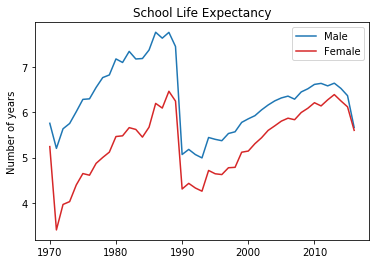

In [36]:
#For a better look in diff between the 2 genders
plt.plot(db_afr_ind_6.Year,db_afr_ind_6.Value,db_afr_ind_5.Year,db_afr_ind_5.Value,'tab:red')
plt.title('School Life Expectancy')
plt.legend(['Male','Female'])
plt.ylabel('Number of years')

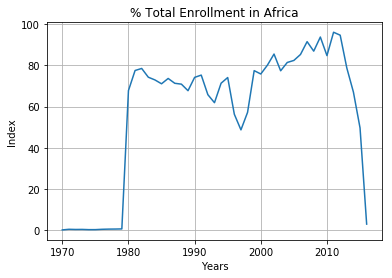

In [37]:
'''
Here we tried to look for a new attribute to see things better, the ratio of the enrolled people by the school aged people,
to look at the percentage of people going to school in Africa as a mean value, across the years.
'''

db_afr_ind_new = db_afr_indexes.copy()

nom_1 = db_afr_ind_new[db_afr_ind_new.Indicator == 'SE.PRM.ENRR.NUM.TO']

denom_1 = db_afr_ind_new[db_afr_ind_new.Indicator == 'SE.POP.PRM.NENR.TOT']

nom = nom_1['Value']
nom_f = nom.reset_index(drop=True)

denom = denom_1['Value']
denom_f = denom.reset_index(drop=True)

res = (nom_f/denom_f)*100

dates = range(1970,2017)

plt.plot(dates,res)
plt.xlabel('Years')
plt.ylabel('Index')
plt.title('% Total Enrollment in Africa')
plt.grid()
plt.show()

The big drop at the end is only due to unvailable data in recent years.. Information and Statistics may be not update
for many countries.

In [38]:
# Countries and regions Names?
countries_data.CountryName.unique()

array(['AFRICA', 'Cameroon', 'Central African Republic', 'Chad',
       'Congo, Dem. Rep.', 'Congo, Rep.', 'Equatorial Guinea', 'Gabon',
       'Sao Tome and Principe', 'Burundi', 'Comoros', 'Djibouti',
       'Eritrea', 'Ethiopia', 'Kenya', 'Rwanda', 'Seychelles', 'Somalia',
       'South Sudan', 'Sudan', 'Tanzania', 'Uganda', 'Algeria', 'Egypt',
       'Libya', 'Mauritania', 'Morocco', 'Tunisia', 'Angola', 'Botswana',
       'Lesotho', 'Madagascar', 'Malawi', 'Mauritius', 'Mozambique',
       'Namibia', 'South Africa', 'Swaziland', 'Zambia', 'Zimbabwe',
       'Benin', 'Burkina Faso', 'Cape Verde', "Cote d'Ivoire", 'Gambia',
       'Ghana', 'Guinea', 'Guinea-Bissau', 'Liberia', 'Mali', 'Niger',
       'Nigeria', 'Senegal', 'Sierra Leone', 'Togo'], dtype=object)

In [49]:
#From the list above, we see that multiple values are not needed (not only countries but also regions and set of countries
#that verify certain conditions are present)
#We will then eliminate this noisy data for these observations

location_afr = [9,18]
geo_data = os.path.join('./maps/', 'custom-afr-bibi.json')

chosen_year = 2010

Countries_Only = ['Cameroon', 'Central African Republic','Chad', 'Congo, Dem. Rep.', 'Congo, Rep.', 'Equatorial Guinea',
                 'Gabon', 'Sao Tome and Principe', 'Burundi', 'Comoros', 'Djibouti', 'Eritrea', 'Ethiopia','Kenya',
                 'Rwanda', 'Seychelles', 'Somalia', 'South Sudan', 'Sudan', 'Tanzania', 'Uganda', 'Algeria', 'Egypt',
                 'Libya', 'Mauritania', 'Morocco', 'Tunisia', 'Angola', 'Botswana', 'Lesotho', 'Madagascar', 'Malawi',
                 'Mauritius', 'Mozambique', 'Namibia', 'South Africa', 'Swaziland', 'Zambia', 'Zimbabwe', 'Benin',
                 'Burkina Faso', 'Cape Verde', "Cote d'Ivoire", 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Liberia',
                 'Mali', 'Niger', 'Nigeria', 'Senegal', 'Sierra Leone','Togo']

map_data = countries_data[['Country','CountryName','Year','Indicator','Value']].copy()

map_data = map_data[map_data.CountryName.isin(Countries_Only)]

map_data = map_data[map_data.Year == chosen_year]

map_data

,Country,CountryName,Year,Indicator,Value
51981,CMR,Cameroon,2010,FP.CPI.TOTL,1.288848e+02
52020,CMR,Cameroon,2010,FP.CPI.TOTL.ZG,1.279343e+00
52097,CMR,Cameroon,2010,GC.BAL.CASH.GD.CD,-3.229825e+08
52137,CMR,Cameroon,2010,GC.BAL.CASH.GD.ZS,-1.367266e+00
52197,CMR,Cameroon,2010,GC.REV.TOTL.GD.CD,3.850323e+09
...,...,...,...,...,...
2778702,GMB,Gambia,2010,DC.DAC.ODA.BIL.LUXL.CD,1.200000e+05
2778717,GMB,Gambia,2010,DC.DAC.NOF.BIL.LUXL.CD,1.200000e+05
2779406,GNB,Guinea-Bissau,2010,DC.DAC.ODA.BIL.AUSL.CD,1.600000e+05
2779418,GNB,Guinea-Bissau,2010,DC.DAC.NOF.BIL.AUSL.CD,1.600000e+05


### Here we will draw some maps to have a closer look at what these indexes values look like in each country,   for some specific year.

### We still haven't done the analysis for this part.

In [50]:
#1
map_data_1 = map_data[map_data.Indicator == 'SE.PRM.ENRR']

thresh = 105

def africa_colors_1(country):
    """Maps drachneya to drachneya etc.."""
    if not( map_data_1['Country'].str.contains(country).any()) : return '#00ff00'
    grrr = map_data_1.loc[map_data_1['Country'] == country,'Value'].values[0] > thresh
    if grrr :
        return '#0000ff'
    else:
        return '#ff0000'
    
    
m_afr_1 = folium.Map(location_afr, tiles='cartodbpositron', zoom_start=3)

folium.GeoJson(
    geo_data,
    style_function=lambda feature: {
        'fillColor': africa_colors_1(feature['id']),
        'color' : 'black',
        'weight' : 2,
        'dashArray' : '5, 5'
        }
    ).add_to(m_afr_1)

m_afr_1

In [41]:
m_afr_1 = folium.Map(location_afr, zoom_start=3)
m_afr_1.choropleth(geo_data=geo_data, data=map_data_1,
             columns=['Country', 'Value'],
             key_on='feature.id',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='aw jek')

m_afr_1

In [42]:
#2
map_data_2 = map_data[map_data.Indicator == 'SE.PRM.ENRL.TC.ZS']

m_afr_2 = folium.Map(location_afr, zoom_start=3)
m_afr_2.choropleth(geo_data=geo_data, data=map_data_2,
             columns=['Country', 'Value'],
             key_on='feature.id',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='aw jek')

m_afr_2

In [43]:
#3
map_data_3 = map_data[map_data.Indicator == 'SE.POP.PRM.NENR.TOT']

m_afr_3 = folium.Map(location_afr, zoom_start=3)
m_afr_3.choropleth(geo_data=geo_data, data=map_data_3,
             columns=['Country', 'Value'],
             key_on='feature.id',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.4,
             legend_name='aw jek')

m_afr_3

In [44]:
#4
map_data_4 = map_data[map_data.Indicator == 'SE.PRM.ENRR.NUM.TO']

m_afr_4 = folium.Map(location_afr, zoom_start=3)
m_afr_4.choropleth(geo_data=geo_data, data=map_data_4,
             columns=['Country', 'Value'],
             key_on='feature.id',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.4,
             legend_name='aw jek')

m_afr_4

In [45]:
#5
map_data_5 = map_data[map_data.Indicator == 'SE.YRS.SCHL.FE']

m_afr_5 = folium.Map(location_afr, zoom_start=3)
m_afr_5.choropleth(geo_data=geo_data, data=map_data_5,
             columns=['Country', 'Value'],
             key_on='feature.id',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.4,
             legend_name='aw jek')

m_afr_5

In [46]:
#6
map_data_6 = map_data[map_data.Indicator == 'SE.YRS.SCHL.MA']

m_afr_6 = folium.Map(location_afr, zoom_start=3)
m_afr_6.choropleth(geo_data=geo_data, data=map_data_6,
             columns=['Country', 'Value'],
             key_on='feature.id',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.4,
             legend_name='aw jek')

m_afr_6

In [47]:
db_zero_pivot = pd.pivot_table(countries_data, values='Value', index=['Country', 'Year'], columns=['Indicator'])

In [48]:
development_indicators = ['SP.DYN.HDIV','SL.TLF.15UP.UEM','NY.GDP.PCAP.CD','FP.CPI.TOTL','CPI_S','SP.DYN.GIIV','SP.DYN.HPIV','SP.DYN.LE00.IN']
db_dev_inds = db_zero_pivot[development_indicators]

### Socio-Economic Growth part

In [23]:
countries_data_trimmed = countries_data[(countries_data.Year <= 2019) & (countries_data.Year >= 1960)]
countries_data_trimmed = countries_data_trimmed[countries_data_trimmed.CountryName.isin(Countries_Only)]
countries_data_trimmed.replace(to_replace=0.0, value=np.nan, inplace=True)
indicators_countries_trimmed = pd.pivot_table(countries_data_trimmed, values='Value', index=['Country','Year'], columns=['Indicator'])
indicators_countries_trimmed

Indicator     AFDB_CPIA_EM_DB_S  AFDB_CPIA_EM_FP_S  AFDB_CPIA_EM_MM_S  \
Country Year                                                            
AFR     1960                NaN                NaN                NaN   
        1961                NaN                NaN                NaN   
        1962                NaN                NaN                NaN   
        1963                NaN                NaN                NaN   
        1964                NaN                NaN                NaN   
...                         ...                ...                ...   
ZWE     2015                2.5                2.5                3.0   
        2016                2.5                2.0                3.0   
        2017                NaN                NaN                NaN   
        2018                NaN                NaN                NaN   
        2019                NaN                NaN                NaN   

Indicator     AFDB_CPIA_EM_S  AFDB_CPIA_IRI_ID_S  AFDB_CPIA_IRI_RI_S  \
Country Year                                                           
AFR     1960             NaN                 NaN                 NaN   
        1961             NaN                 NaN                 NaN   
        1962             NaN                 NaN                 NaN   
        1963             NaN                 NaN                 NaN   
        1964             NaN                 NaN                 NaN   
...                      ...                 ...                 ...   
ZWE     2015             NaN                 2.7                2.50   
        2016             NaN                 2.7                2.75   
        2017             NaN                 NaN                 NaN   
        2018             NaN                 NaN                 NaN   
        2019             NaN                 NaN                 NaN   

Indicator     AFDB_CPIA_N  AFDB_CPIA_PSIE_BHR_S  AFDB_CPIA_PSIE_EPRU_S  \
Country Year                                                             
AFR     1960          NaN                   NaN                    NaN   
        1961          NaN                   NaN                    NaN   
        1962          NaN                   NaN                    NaN   
        1963          NaN                   NaN                    NaN   
        1964          NaN                   NaN                    NaN   
...                   ...                   ...                    ...   
ZWE     2015          NaN               3.33333                2.16667   
        2016          NaN               3.66667                2.16667   
        2017          NaN                   NaN                    NaN   
        2018          NaN                   NaN                    NaN   
        2019          NaN                   NaN                    NaN   

Indicator     AFDB_CPIA_PSIE_EPR_S  ...  TG.WEO.TXGXO_R.KD  TG.WEO.TXG_D.WD  \
Country Year                        ...                                       
AFR     1960                   NaN  ...                NaN              NaN   
        1961                   NaN  ...                NaN              NaN   
        1962                   NaN  ...                NaN              NaN   
        1963                   NaN  ...                NaN              NaN   
        1964                   NaN  ...                NaN              NaN   
...                            ...  ...                ...              ...   
ZWE     2015                   2.5  ...       1.260197e+09       286.796901   
        2016                   2.5  ...       1.319484e+09       280.518802   
        2017                   NaN  ...       1.263811e+09       302.366614   
        2018                   NaN  ...       1.331340e+09       299.264516   
        2019                   NaN  ...       1.410437e+09       296.748918   

Indicator     TG.WEO.TXG_R.KD  TG.WEO.TXG_R.ZG  TG.WEO.TXS.CD  TG.WEO.TX_D.WD  \
Country Year                             

In [24]:
ind_by_occurence_trimmed = countries_data_trimmed[['Year','Indicator']].groupby(['Indicator']).count()
ind_by_occurence_trimmed = ind_by_occurence_trimmed.reset_index() 
ind_by_occurence_trimmed.rename(columns={'Year':'Occurence'},inplace = True)
ind_by_occurence_trimmed.sort_values(by='Occurence', ascending=False, inplace = True)
ind_by_occurence_trimmed = ind_by_occurence_trimmed[ind_by_occurence_trimmed.Occurence >= 500]
ind_by_occurence_trimmed = ind_by_occurence_trimmed.merge(indicators_data[['Name','Code']],how='left',left_on='Indicator',right_on = 'Code')
ind_by_occurence_trimmed.drop(columns='Code',inplace=True)
ind_by_occurence_trimmed

,Indicator,Occurence,Name
0,SP.POP.5064.MA.IN,3300,"Population ages 50 to 64, male"
1,SP.POP.0514.TO,3300,"Population ages 5-14, total"
2,SP.POP.1564.ZS,3300,"Population ages 15-64, (% of total)"
3,SP.DYN.LE00.FE.MA.ZS,3300,"Life expectancy at birth, Ratio of female to Male"
4,SP.POP.65UP.TO,3300,"Population ages 65 and above, total"
...,...,...,...
889,DC.DAC.NOF.MUL.SEP.CD,511,Net Total Multilateral Official Flows - SAF+ES...
890,PS.DB.PI.DI.IN,509,Protecting Investors - Disclosure Index (0-10)
891,PS.DB.DL.COST.ZS,508,Dealing with Licenses - Cost (% of income per ...
892,SP.DYN.HPIV,503,Human poverty index (HPI)


In [25]:
ind_by_occurence_trimmed.to_csv('./data/Indicators_not_nan.csv', sep='\t')

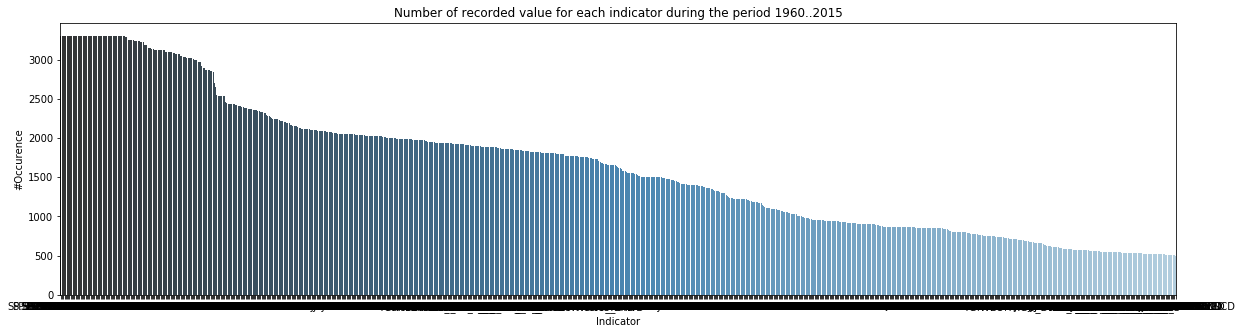

In [27]:
plt.figure(figsize=(20,5))
pl = sns.barplot(ind_by_occurence_trimmed.Indicator, y=ind_by_occurence_trimmed.Occurence, palette="Blues_d")
pl.set_title('Number of recorded value for each indicator during the period 1960..2015')
pl.set_ylabel('#Occurence')
plt.show()

SP.DYN.HDIV				Human development index (HDI)
SL.TLF.15UP.UEM			Unemployment rate, (aged 15 over) (%)
NY.GDP.PCAP.CD			GDP per capita,(current US$)
FP.CPI.TOTL				Inflation, consumer prices  index (2000 = 100)
CPI_S					Corruption Perception Index, Overall Country Score
SP.DYN.GIIV				Gender Inequality Index, value (GII)
SP.DYN.HPIV				HUMAN POVERTY INDEX
SP.DYN.LE00.IN 			Life expectancy at birth, total (years)

## social indicators
SP.DYN.LE00.IN	    1980	Life expectancy at birth, total (years)  
SP.URB.GROW	        1980	Urban population growth (annual %)  
SP.RUR.TOTL.ZS	    1980	Rural population (% of total population)  
* SP.URB.TOTL.IN.ZS	1980	Urban population (% of total)  
SH.IMM.IBCG	        1799	Immunization coverage, BCG (% of one-year-old children)  
EG.ELC.CONS.TOTL.KH	1741	Total Net Electricity Consumption  
* SL.EMP.TOTL.SP.ZS	1321	Employment to population ratio, 15+, total (%)  
SH.XPD.PUBL.ZS	    1051	Public Expenditure on Health (as % of GDP)  
* SE.XPD.BUDG.ZS	    0536	Public expenditure on Education (% of budget)  

## economic indicators
* NY.GDP.PCAP.KD	1918	GDP per capita,(constant 2000 Prices, USD  
NY.GDP.MKTP.KD	1918	GDP (constant 2000 USD  
* AG.POP.EAC.TOT	1908	Economically active population ('000)  
FP.CPI.TOTL	    1820	Inflation, consumer prices  index (2000 = 100)  
* NY.GNP.PCAP.CD	1766	GNI per capita, Atlas method (current USD)  
NY.GNP.MKTP.CD	1766	GNI (current USD)  
AG.PRD.FOOD.XD	1826	Food production index (1999-2001 = 100)  
* POP.EAC.FE.ZS	1352	Women's Share of Total Labor Force (%)  

## education indicators
SE.PRM.ENRR	    1620	School enrollment, primary (% gross)  
SE.YRS.SCHL.TO	1553	School Life Expectancy - total (years)  
SE.SEC.ENRR	    1238	School enrollment, secondary (% gross)  

In [34]:
#Split train
indicators_countries_train = indicators_countries_trimmed[indicators_countries_trimmed.index.get_level_values(1) < 2020]




In [35]:
#fill nan
indicators_countries_filled = indicators_countries_train.copy()
indicators_countries_filled.update(indicators_countries_filled.groupby('Country').ffill())
indicators_countries_filled.update(indicators_countries_filled.groupby('Country').bfill())
indicators_countries_filled

Indicator     AFDB_CPIA_EM_DB_S  AFDB_CPIA_EM_FP_S  AFDB_CPIA_EM_MM_S  \
Country Year                                                            
AFR     1960                NaN                NaN                NaN   
        1961                NaN                NaN                NaN   
        1962                NaN                NaN                NaN   
        1963                NaN                NaN                NaN   
        1964                NaN                NaN                NaN   
...                         ...                ...                ...   
ZWE     2015                2.5                2.5                3.0   
        2016                2.5                2.0                3.0   
        2017                2.5                2.0                3.0   
        2018                2.5                2.0                3.0   
        2019                2.5                2.0                3.0   

Indicator     AFDB_CPIA_EM_S  AFDB_CPIA_IRI_ID_S  AFDB_CPIA_IRI_RI_S  \
Country Year                                                           
AFR     1960             NaN                 NaN                 NaN   
        1961             NaN                 NaN                 NaN   
        1962             NaN                 NaN                 NaN   
        1963             NaN                 NaN                 NaN   
        1964             NaN                 NaN                 NaN   
...                      ...                 ...                 ...   
ZWE     2015            1.83                 2.7                2.50   
        2016            1.83                 2.7                2.75   
        2017            1.83                 2.7                2.75   
        2018            1.83                 2.7                2.75   
        2019            1.83                 2.7                2.75   

Indicator     AFDB_CPIA_N  AFDB_CPIA_PSIE_BHR_S  AFDB_CPIA_PSIE_EPRU_S  \
Country Year                                                             
AFR     1960          NaN                   NaN                    NaN   
        1961          NaN                   NaN                    NaN   
        1962          NaN                   NaN                    NaN   
        1963          NaN                   NaN                    NaN   
        1964          NaN                   NaN                    NaN   
...                   ...                   ...                    ...   
ZWE     2015         40.0               3.33333                2.16667   
        2016         40.0               3.66667                2.16667   
        2017         40.0               3.66667                2.16667   
        2018         40.0               3.66667                2.16667   
        2019         40.0               3.66667                2.16667   

Indicator     AFDB_CPIA_PSIE_EPR_S  ...  TG.WEO.TXGXO_R.KD  TG.WEO.TXG_D.WD  \
Country Year                        ...                                       
AFR     1960                   NaN  ...       8.171153e+10        58.227286   
        1961                   NaN  ...       8.171153e+10        58.227286   
        1962                   NaN  ...       8.171153e+10        58.227286   
        1963                   NaN  ...       8.171153e+10        58.227286   
        1964                   NaN  ...       8.171153e+10        58.227286   
...                            ...  ...                ...              ...   
ZWE     2015                   2.5  ...       1.260197e+09       286.796901   
        2016                   2.5  ...       1.319484e+09       280.518802   
        2017                   2.5  ...       1.263811e+09       302.366614   
        2018                   2.5  ...       1.331340e+09       299.264516   
        2019                   2.5  ...       1.410437e+09       296.748918   

Indicator     TG.WEO.TXG_R.KD  TG.WEO.TXG_R.ZG  TG.WEO.TXS.CD  TG.WEO.TX_D.WD  \
Country Year                             

In [36]:
indicators_countries_interpolated = indicators_countries_train.copy()
indicators_countries_interpolated = indicators_countries_interpolated.groupby('Country').apply(lambda group: group.interpolate(method='linear',axis=0,limit_direction='both', limit_area='inside'))
indicators_countries_interpolated

Indicator     AFDB_CPIA_EM_DB_S  AFDB_CPIA_EM_FP_S  AFDB_CPIA_EM_MM_S  \
Country Year                                                            
AFR     1960                NaN                NaN                NaN   
        1961                NaN                NaN                NaN   
        1962                NaN                NaN                NaN   
        1963                NaN                NaN                NaN   
        1964                NaN                NaN                NaN   
...                         ...                ...                ...   
ZWE     2015                2.5                2.5                3.0   
        2016                2.5                2.0                3.0   
        2017                NaN                NaN                NaN   
        2018                NaN                NaN                NaN   
        2019                NaN                NaN                NaN   

Indicator     AFDB_CPIA_EM_S  AFDB_CPIA_IRI_ID_S  AFDB_CPIA_IRI_RI_S  \
Country Year                                                           
AFR     1960             NaN                 NaN                 NaN   
        1961             NaN                 NaN                 NaN   
        1962             NaN                 NaN                 NaN   
        1963             NaN                 NaN                 NaN   
        1964             NaN                 NaN                 NaN   
...                      ...                 ...                 ...   
ZWE     2015             NaN                 2.7                2.50   
        2016             NaN                 2.7                2.75   
        2017             NaN                 NaN                 NaN   
        2018             NaN                 NaN                 NaN   
        2019             NaN                 NaN                 NaN   

Indicator     AFDB_CPIA_N  AFDB_CPIA_PSIE_BHR_S  AFDB_CPIA_PSIE_EPRU_S  \
Country Year                                                             
AFR     1960          NaN                   NaN                    NaN   
        1961          NaN                   NaN                    NaN   
        1962          NaN                   NaN                    NaN   
        1963          NaN                   NaN                    NaN   
        1964          NaN                   NaN                    NaN   
...                   ...                   ...                    ...   
ZWE     2015          NaN               3.33333                2.16667   
        2016          NaN               3.66667                2.16667   
        2017          NaN                   NaN                    NaN   
        2018          NaN                   NaN                    NaN   
        2019          NaN                   NaN                    NaN   

Indicator     AFDB_CPIA_PSIE_EPR_S  ...  TG.WEO.TXGXO_R.KD  TG.WEO.TXG_D.WD  \
Country Year                        ...                                       
AFR     1960                   NaN  ...                NaN              NaN   
        1961                   NaN  ...                NaN              NaN   
        1962                   NaN  ...                NaN              NaN   
        1963                   NaN  ...                NaN              NaN   
        1964                   NaN  ...                NaN              NaN   
...                            ...  ...                ...              ...   
ZWE     2015                   2.5  ...       1.260197e+09       286.796901   
        2016                   2.5  ...       1.319484e+09       280.518802   
        2017                   NaN  ...       1.263811e+09       302.366614   
        2018                   NaN  ...       1.331340e+09       299.264516   
        2019                   NaN  ...       1.410437e+09       296.748918   

Indicator     TG.WEO.TXG_R.KD  TG.WEO.TXG_R.ZG  TG.WEO.TXS.CD  TG.WEO.TX_D.WD  \
Country Year                             

We chose these education indicators 

-SE.PRM.ENRR.NUM.TO : primary enrollment in total 

-SE.SEC.ENRR.NUM.TO : secondary enrollment in total

-SE.YRS.SCHL.FE : school life expectancy female

-SE.YRS.SCHL.MA : school life expectancy male

-SE.PRM.ENRL.TC.ZS : pupil teacher ratio primary 

and we normalized the total primary and secondary enrollment indicators with reference to the total population in each country each year 





In [37]:
education_indicators = ['SE.PRM.ENRR.NUM.TO','SE.SEC.ENRR.NUM.TO','SE.YRS.SCHL.FE','SE.YRS.SCHL.MA','SE.PRM.ENRL.TC.ZS']
# Normalize education indicators by total population 'SP.POP.TOTL' 
education_indicators_normalize =  ['SE.PRM.ENRR.NUM.TO','SE.SEC.ENRR.NUM.TO']
for y in education_indicators_normalize:
    indicators_countries_interpolated[y] = indicators_countries_interpolated.apply(lambda x : 100*x[y]/x['SP.POP.TOTL'],axis=1)
indicators_countries_interpolated

Indicator     AFDB_CPIA_EM_DB_S  AFDB_CPIA_EM_FP_S  AFDB_CPIA_EM_MM_S  \
Country Year                                                            
AFR     1960                NaN                NaN                NaN   
        1961                NaN                NaN                NaN   
        1962                NaN                NaN                NaN   
        1963                NaN                NaN                NaN   
        1964                NaN                NaN                NaN   
...                         ...                ...                ...   
ZWE     2015                2.5                2.5                3.0   
        2016                2.5                2.0                3.0   
        2017                NaN                NaN                NaN   
        2018                NaN                NaN                NaN   
        2019                NaN                NaN                NaN   

Indicator     AFDB_CPIA_EM_S  AFDB_CPIA_IRI_ID_S  AFDB_CPIA_IRI_RI_S  \
Country Year                                                           
AFR     1960             NaN                 NaN                 NaN   
        1961             NaN                 NaN                 NaN   
        1962             NaN                 NaN                 NaN   
        1963             NaN                 NaN                 NaN   
        1964             NaN                 NaN                 NaN   
...                      ...                 ...                 ...   
ZWE     2015             NaN                 2.7                2.50   
        2016             NaN                 2.7                2.75   
        2017             NaN                 NaN                 NaN   
        2018             NaN                 NaN                 NaN   
        2019             NaN                 NaN                 NaN   

Indicator     AFDB_CPIA_N  AFDB_CPIA_PSIE_BHR_S  AFDB_CPIA_PSIE_EPRU_S  \
Country Year                                                             
AFR     1960          NaN                   NaN                    NaN   
        1961          NaN                   NaN                    NaN   
        1962          NaN                   NaN                    NaN   
        1963          NaN                   NaN                    NaN   
        1964          NaN                   NaN                    NaN   
...                   ...                   ...                    ...   
ZWE     2015          NaN               3.33333                2.16667   
        2016          NaN               3.66667                2.16667   
        2017          NaN                   NaN                    NaN   
        2018          NaN                   NaN                    NaN   
        2019          NaN                   NaN                    NaN   

Indicator     AFDB_CPIA_PSIE_EPR_S  ...  TG.WEO.TXGXO_R.KD  TG.WEO.TXG_D.WD  \
Country Year                        ...                                       
AFR     1960                   NaN  ...                NaN              NaN   
        1961                   NaN  ...                NaN              NaN   
        1962                   NaN  ...                NaN              NaN   
        1963                   NaN  ...                NaN              NaN   
        1964                   NaN  ...                NaN              NaN   
...                            ...  ...                ...              ...   
ZWE     2015                   2.5  ...       1.260197e+09       286.796901   
        2016                   2.5  ...       1.319484e+09       280.518802   
        2017                   NaN  ...       1.263811e+09       302.366614   
        2018                   NaN  ...       1.331340e+09       299.264516   
        2019                   NaN  ...       1.410437e+09       296.748918   

Indicator     TG.WEO.TXG_R.KD  TG.WEO.TXG_R.ZG  TG.WEO.TXS.CD  TG.WEO.TX_D.WD  \
Country Year                             

In [38]:
#y_indicator = 'NY.GDP.PCAP.KD' #GDP per capita
#y_indicator = 'SE.XPD.BUDG.ZS' #Public expenditure on Education
#y_indicator = 'POP.EAC.FE.ZS' # percentage of women participation in workforce
#y_indicator = 'SL.EMP.TOTL.SP.ZS' # employment to population ratio
y_indicator = 'SP.DYN.HDIV' # human development index
X_education_train = indicators_countries_interpolated[education_indicators + [y_indicator]].dropna()
Y_education_train = X_education_train[y_indicator]
X_education_train.drop(columns = y_indicator,inplace=True)

In [39]:
X_education_train.isna().sum()
#[country for country in indicators_countries_interpolated.index if pd.isna(indicators_countries_interpolated.loc[country]['SE.TERT.ENRR.NUM.TOT'])]

Indicator
SE.PRM.ENRR.NUM.TO    0
SE.SEC.ENRR.NUM.TO    0
SE.YRS.SCHL.FE        0
SE.YRS.SCHL.MA        0
SE.PRM.ENRL.TC.ZS     0
dtype: int64

In [190]:
'''
# see which countries have nan values
countries_no_expenditure_on_education = [country for country in indicators_countries_interpolated.index if pd.isna(indicators_countries_interpolated.loc[country][y_indicator])]
# drop countries with nan elements
X_education.drop(countries_no_expenditure_on_education,inplace = True)
Y_education = indicators_countries_interpolated[y_indicator].drop(countries_no_expenditure_on_education)
'''

'\n# see which countries have nan values\ncountries_no_expenditure_on_education = [country for country in indicators_countries_interpolated.index if pd.isna(indicators_countries_interpolated.loc[country][y_indicator])]\n# drop countries with nan elements\nX_education.drop(countries_no_expenditure_on_education,inplace = True)\nY_education = indicators_countries_interpolated[y_indicator].drop(countries_no_expenditure_on_education)\n'

In [40]:
scaler = StandardScaler().fit(X_education_train)
X_education_train_scaled = scaler.transform(X_education_train)
X_education_train_scaled = pd.DataFrame(X_education_train_scaled, columns = X_education_train.columns)
rr = RidgeCV(alphas=np.arange(1,4000),  scoring='neg_mean_squared_error', store_cv_values=True)
rr.fit(X_education_train_scaled,Y_education_train)
rr.alpha_

3

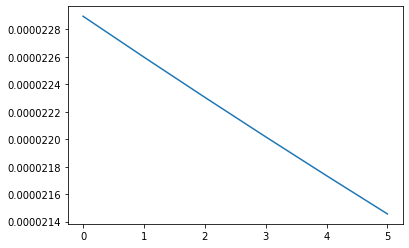

In [41]:
regression_scores = rr.cv_values_.mean(axis=0)
plt.plot(regression_scores[range(2*rr.alpha_)])

In [42]:
coefs = pd.DataFrame(rr.coef_,index = X_education_train.columns, columns = ['weight'])
coefs

,weight
Indicator,
SE.PRM.ENRR.NUM.TO,-0.034272
SE.SEC.ENRR.NUM.TO,0.082319
SE.YRS.SCHL.FE,0.075036
SE.YRS.SCHL.MA,-0.006230
SE.PRM.ENRL.TC.ZS,-0.007334


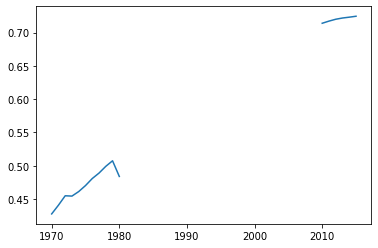

In [43]:
plt.plot(indicators_countries_train[y_indicator].loc['TUN'])

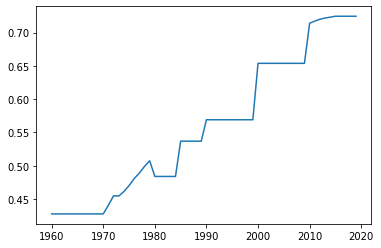

In [45]:
plt.plot(indicators_countries_filled[y_indicator].loc['TUN'])

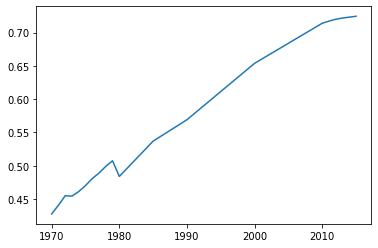

In [44]:
plt.plot(indicators_countries_interpolated[y_indicator].loc['TUN'])

In [46]:
indicators_countries_train[y_indicator].loc['TUN',1970]

0.42773599999999995

In [47]:
# Prepare test data
## make a forward padding of missing data to take most recent available value
year_test = 2019
indictors_countries_test = indicators_countries_trimmed.copy()
indictors_countries_test.update(indictors_countries_test.groupby('Country').ffill())
indictors_countries_test = indictors_countries_test[indictors_countries_test.index.get_level_values(1) == year_test]

## Scale certain education indicators by total population number
for y in education_indicators_normalize:
    indictors_countries_test[y] = indictors_countries_test.apply(lambda x : 100*x[y]/x['SP.POP.TOTL'],axis=1)
    
## Extract x & y test
X_education_test = indictors_countries_test[education_indicators + [y_indicator]].dropna()
Y_education_test = pd.DataFrame(X_education_test[y_indicator], index = X_education_test.index,columns = [y_indicator])
X_education_test = X_education_test[education_indicators]
## Normalize to std =1 & mean=0
scaler = StandardScaler().fit(X_education_test)
X_education_test_scaled = scaler.transform(X_education_test)
X_education_test_scaled = pd.DataFrame(X_education_test_scaled, columns = X_education_test.columns)
# predict output
Y_education_pred = pd.DataFrame(rr.predict(X_education_test_scaled), index = Y_education_test.index,columns = [y_indicator])
#regression_output = pd.DataFrame({Y_education_pred[y_indicator],Y_education_test[y_indicator]},columns = ['prediction','actual'])
regression_output = Y_education_pred.merge(Y_education_test,left_index = True,right_index = True,suffixes = ('_prediction','_actual'))
regression_output['absolute error'] = abs(regression_output[y_indicator+'_prediction'] - regression_output[y_indicator+'_actual'])
regression_output

,,SP.DYN.HDIV_prediction,SP.DYN.HDIV_actual,absolute error
Country,Year,,,
AFR,2019,0.333672,0.529507,0.195835
AGO,2019,0.288534,0.533464,0.244930
BDI,2019,0.455194,0.403765,0.051428
BEN,2019,0.505073,0.485096,0.019977
BFA,2019,0.347739,0.401740,0.054001
BWA,2019,0.526984,0.697687,0.170704
CAF,2019,0.223970,0.352440,0.128470
CIV,2019,0.390850,0.473679,0.082830
CMR,2019,0.490416,0.517547,0.027131


In [51]:
#y_test
m_afr_y_test = folium.Map(location_afr, zoom_start=3)
m_afr_y_test.choropleth(geo_data=geo_data, data=Y_education_test.reset_index(),
             columns=['Country', y_indicator],
             key_on='feature.id',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.4,
             legend_name='aw jek')

m_afr_y_test

In [52]:
#y_pred
m_afr_y_pred = folium.Map(location_afr, zoom_start=3)
m_afr_y_pred.choropleth(geo_data=geo_data, data=Y_education_pred.reset_index(),
             columns=['Country', y_indicator],
             key_on='feature.id',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.4,
             legend_name='aw jek')

m_afr_y_pred

## Remarks:
* In all the economic indicators, the weights of the education indicators *SE.YRS.SCHL.FE* (School Life Expectancy, female (year)) and *SE.YRS.SCHL.MA* (School Life Expectancy, male (year)) are always positive and negative, respectively, which indicates that economic development correlates highly with societies that have better gender equality.

In [278]:
country_code = np.array(indicators_countries_interpolated.index.get_level_values(0).unique())
country_code

array(['AFR', 'AGO', 'BDI', 'BEN', 'BFA', 'BWA', 'CAF', 'CIV', 'CMR',
       'COG', 'COM', 'CPV', 'DJI', 'DZA', 'EGY', 'ERI', 'ETH', 'GAB',
       'GHA', 'GIN', 'GMB', 'GNB', 'GNQ', 'KEN', 'LBR', 'LBY', 'LSO',
       'MAR', 'MDG', 'MLI', 'MOZ', 'MRT', 'MUS', 'MWI', 'NAM', 'NER',
       'NGA', 'RWA', 'SDN', 'SEN', 'SLE', 'SOM', 'SSD', 'STP', 'SWZ',
       'SYC', 'TCD', 'TGO', 'TUN', 'TZA', 'UGA', 'ZAF', 'ZAR', 'ZMB',
       'ZWE'], dtype=object)

In [224]:
indicators_tunisia_interpolated = indicators_countries_interpolated[indicators_countries_interpolated\
                                                                   .index.get_level_values(0)=='TUN']
social_indicators = ['SP.URB.TOTL.IN.ZS','SL.EMP.TOTL.SP.ZS','SE.XPD.BUDG.ZS']
economic_indicators = ['NY.GDP.PCAP.KD','AG.POP.EAC.TOT','POP.EAC.FE.ZS']
educational_indicators = ['SE.PRM.ENRR.NUM.TO','SE.SEC.ENRR.NUM.TO',\
                          'SE.YRS.SCHL.FE','SE.YRS.SCHL.MA','SE.PRM.ENRL.TC.ZS']

indicators_tunisia_interpolated = indicators_tunisia_interpolated[educational_indicators+\
                                                                  economic_indicators+\
                                                                  social_indicators]


In [225]:
indicators_tunisia_interpolated

Indicator     SE.PRM.ENRR.NUM.TO  SE.SEC.ENRR.NUM.TO  SE.YRS.SCHL.FE  \
Country Year                                                           
TUN     1960                 NaN                 NaN             NaN   
        1961                 NaN                 NaN             NaN   
        1962                 NaN                 NaN             NaN   
        1963                 NaN                 NaN             NaN   
        1964                 NaN                 NaN             NaN   
        1965                 NaN                 NaN             NaN   
        1966                 NaN                 NaN             NaN   
        1967                 NaN                 NaN             NaN   
        1968                 NaN                 NaN             NaN   
        1969                 NaN                 NaN             NaN   
        1970                 NaN                 NaN             NaN   
        1971            0.180892                 NaN         5.82378   
        1972            0.173199                 NaN         5.62041   
        1973            0.165743            0.000345         5.35004   
        1974            0.158917            0.000329         5.25626   
        1975            0.161080            0.000298         5.51218   
        1976            0.161317            0.000267         5.65410   
        1977            0.163719            0.000235         5.85848   
        1978            0.163817            0.000252         6.13741   
        1979            0.161816            0.000316         6.26365   
        1980           16.231322            4.151774         6.42113   
        1981           16.104247            4.212299         6.54990   
        1982           16.169124            4.633724         6.92401   
        1983           16.601952            5.124690         7.42969   
        1984           16.813364            5.435579         7.81613   
        1985           17.007415            5.727179         8.17015   
        1986           17.197510            6.093811         8.49366   
        1987           17.245171            5.967490         8.59417   
        1988           17.098747            6.101092         8.67631   
        1989           16.563167            6.583135         8.79346   
        1990           16.719943            6.643587         6.42365   
        1991           16.698942            6.706591         6.49868   
        1992           16.577677            6.854103         6.52909   
        1993           16.402713            7.278442         6.54438   
        1994           16.483159            8.007021         6.65725   
        1995           16.258103            8.593059         6.65234   
        1996           15.870703            9.176272         6.60020   
        1997           15.461345            9.406605         6.52923   
        1998           15.265869           10.416367         6.56684   
        1999           15.024408           11.025681         6.63910   
        2000           14.576420           11.383371         6.66019   
        2001           14.039966           11.681189         6.68981   
        2002           13.439570           11.854658         6.66424   
        2003           12.849005           11.660290         6.61743   
        2004           12.262086           12.079055         6.55486   
        2005           11.722877           12.268951         6.50294   
        2006           11.125588           12.230209         6.39554   
        2007           10.378205           12.314340         6.19048   
        2008            9.958070           12.098664         6.14479   
        2009            9.741714           11.419954         6.20094   
        2010            9.682209           10.939109         6.30824   
        2011            9.554628           10.708866         6.34814   
        2012            9.618856           10.218684         6.49616   
        2013            9.661270        

In [231]:
#1992/2013
indicators_tunisia_interpolated = indicators_tunisia_interpolated[indicators_tunisia_interpolated\
                                                                 .index.get_level_values(1)>=1992]
indicators_tunisia_interpolated = indicators_tunisia_interpolated[indicators_tunisia_interpolated\
                                                                 .index.get_level_values(1)<=2013]
indicators_tunisia_interpolated

Indicator     SE.PRM.ENRR.NUM.TO  SE.SEC.ENRR.NUM.TO  SE.YRS.SCHL.FE  \
Country Year                                                           
TUN     1992           16.577677            6.854103         6.52909   
        1993           16.402713            7.278442         6.54438   
        1994           16.483159            8.007021         6.65725   
        1995           16.258103            8.593059         6.65234   
        1996           15.870703            9.176272         6.60020   
        1997           15.461345            9.406605         6.52923   
        1998           15.265869           10.416367         6.56684   
        1999           15.024408           11.025681         6.63910   
        2000           14.576420           11.383371         6.66019   
        2001           14.039966           11.681189         6.68981   
        2002           13.439570           11.854658         6.66424   
        2003           12.849005           11.660290         6.61743   
        2004           12.262086           12.079055         6.55486   
        2005           11.722877           12.268951         6.50294   
        2006           11.125588           12.230209         6.39554   
        2007           10.378205           12.314340         6.19048   
        2008            9.958070           12.098664         6.14479   
        2009            9.741714           11.419954         6.20094   
        2010            9.682209           10.939109         6.30824   
        2011            9.554628           10.708866         6.34814   
        2012            9.618856           10.218684         6.49616   

Indicator     SE.YRS.SCHL.MA  SE.PRM.ENRL.TC.ZS  NY.GDP.PCAP.KD  \
Country Year                                                      
TUN     1992         7.38176        2640.503212     1597.122821   
        1993         7.29101        2619.308164     1598.372898   
        1994         7.34105        2629.071838     1617.597475   
        1995         7.26414        2522.658245     1626.971996   
        1996         7.13620        2452.949722     1716.494211   
        1997         7.01014        2414.129549     1785.142350   
        1998         7.02667        2408.110262     1851.048744   
        1999         7.07335        2386.148503     1941.113827   
        2000         7.05838        2321.045114     2004.650274   
        2001         7.01887        2269.377777     2083.300820   
        2002         6.96295        2189.224850     2101.854265   
        2003         6.88925        2153.775065     2200.050778   
        2004         6.81341        2060.639155     2313.009861   
        2005         6.75545        1998.752785     2385.281610   
        2006         6.64531        1914.138193     2496.921353   
        2007         6.44114        1815.285586     2626.854839   
        2008         6.38309        1728.070760     2716.762500   
        2009         6.40592        1697.823566     2770.871663   
        2010         6.51480        1711.542551     2821.521392   
        2011         6.54638        1735.204753     2736.565658   
        2012         6.66287        1714.982550     2811.261916   

Indicator     AG.POP.EAC.TOT  POP.EAC.FE.ZS  SP.URB.TOTL.IN.ZS  \
Country Year                                                     
TUN     1992       2657000.0           21.3          58.842788   
        1993       2746000.0           21.7          59.586986   
        1994       2834000.0           22.1          60.243128   
        1995       2919000.0           22.5          60.588643   
        1996       3005000.0           23.0          60.937663   
        1997       3086000.0           23.4          61.287398   
        1998       3140000.0           23.4          61.651399   
        1999       3192000.0           23.5          62.043832   
        2000       3242000.0           23.5          62.474348   
        2001       3285000.0           23.6          62.946800   
        2

In [274]:
educational_corr = np.zeros((len(educational_indicators),2)) 
#social_corr = np.zeros(len(social_indicators)) 
#economic_corr = np.zeros(len(economic_indicators)) 
for i, x in enumerate(educational_indicators):
    for y in social_indicators:
        educational_corr[i,0] += indicators_tunisia_interpolated[x].corr(indicators_tunisia_interpolated[y],method='spearman')
                                                                        
    educational_corr[i,0] = educational_corr[i,0]/len(social_indicators)    
    for y in economic_indicators:
        educational_corr[i,1] += indicators_tunisia_interpolated[x].corr(indicators_tunisia_interpolated[y],method='spearman')
                                                                        
    educational_corr[i,1] = educational_corr[i,1]/len(economic_indicators)
    
    
    

In [269]:
educational_corr

array([[-0.26099252, -0.94792184],
       [ 0.36071802,  0.729446  ],
       [-0.28338301, -0.62066712],
       [-0.34249385, -0.91767715],
       [-0.28254963, -0.95694861]])

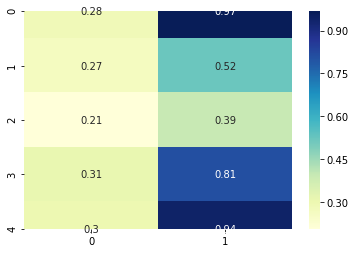

In [276]:
sns.heatmap(np.abs(educational_corr), annot=True, cmap="YlGnBu")

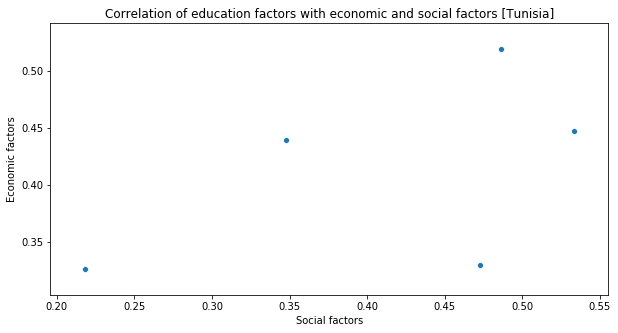

In [204]:
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.scatterplot(np.abs(educational_corr[:,0]), np.abs(educational_corr[:,1]))
ax.set_xlabel('Social factors')
ax.set_ylabel('Economic factors')
ax.set_title('Correlation of education factors with economic and social factors [Tunisia]')
plt.show()

In [282]:
educational_corr = np.zeros((len(country_code),len(educational_indicators),2)) 
for j, country in enumerate(country_code):
    indicators_tunisia_interpolated = indicators_countries_interpolated[indicators_countries_interpolated\
                                                                   .index.get_level_values(0)==country]
    social_indicators = ['SP.URB.TOTL.IN.ZS','SL.EMP.TOTL.SP.ZS','SE.XPD.BUDG.ZS']
    economic_indicators = ['NY.GDP.PCAP.KD','AG.POP.EAC.TOT','POP.EAC.FE.ZS']
    educational_indicators = ['SE.PRM.ENRR.NUM.TO','SE.SEC.ENRR.NUM.TO',\
                              'SE.YRS.SCHL.FE','SE.YRS.SCHL.MA','SE.PRM.ENRL.TC.ZS']

    indicators_tunisia_interpolated = indicators_tunisia_interpolated[educational_indicators+\
                                                                      economic_indicators+\
                                                                      social_indicators]
    indicators_tunisia_interpolated = indicators_tunisia_interpolated[indicators_tunisia_interpolated\
                                                                     .index.get_level_values(1)>=1992]
    indicators_tunisia_interpolated = indicators_tunisia_interpolated[indicators_tunisia_interpolated\
                                                                     .index.get_level_values(1)<=2013]
    indicators_tunisia_interpolated


    for i, x in enumerate(educational_indicators):
        for y in social_indicators:
            educational_corr[j,i,0] += indicators_tunisia_interpolated[x].corr(indicators_tunisia_interpolated[y],method='spearman')

        educational_corr[j,i,0] = educational_corr[j,i,0]/len(social_indicators)    
        for y in economic_indicators:
            educational_corr[j,i,1] += indicators_tunisia_interpolated[x].corr(indicators_tunisia_interpolated[y],method='spearman')

        educational_corr[j,i,1] = educational_corr[j,i,1]/len(economic_indicators)
    

In [288]:
educational_corr

array([[[            nan,             nan],
        [            nan,             nan],
        [            nan,             nan],
        [            nan,             nan],
        [            nan,             nan]],

       [[ 3.56048884e-01,  3.26821825e-01],
        [ 3.59390230e-01,  3.26823911e-01],
        [ 3.39991552e-01,  3.16769647e-01],
        [ 3.56048884e-01,  3.26821825e-01],
        [ 1.26104238e-01,  2.32988795e-01]],

       [[-3.58407189e-02, -1.41921434e-01],
        [-7.48474671e-02, -1.68497655e-01],
        [-6.26019265e-03, -1.16486766e-01],
        [-1.92609504e-02, -1.30238098e-01],
        [-1.16234078e-01, -4.45370080e-02]],

       [[ 2.61541970e-01,  9.86824769e-01],
        [ 2.70354269e-01,  9.92471297e-01],
        [ 2.72694697e-01,  9.92471297e-01],
        [ 2.58291739e-01,  9.68003011e-01],
        [-1.45462766e-01, -3.53284397e-01]],

       [[ 3.25411979e-01,  5.65290591e-01],
        [ 3.25411979e-01,  5.65290591e-01],
        [ 3.25411979e-01

In [292]:
educational_corr.shape

(55, 5, 2)

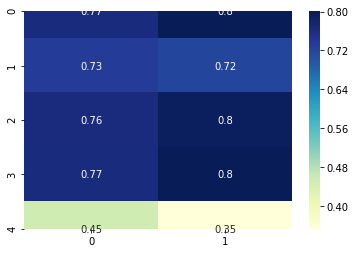

In [307]:
sns.heatmap(np.abs(educational_corr[35,:,:]), annot=True, cmap="YlGnBu")